In [164]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import linear_model, metrics, tree, ensemble, preprocessing
import xgboost as xgb
import catboost
from catboost import utils, Pool
import matplotlib.pyplot as plt

In [37]:
data = pd.read_csv('data/AirPass.csv', sep=',', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     103904 no

In [38]:
data.isnull().sum().sum()

310

In [39]:
data.isnull().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [41]:
data.fillna({'Arrival Delay in Minutes':data['Arrival Delay in Minutes'].median()}, inplace=True)
data['Arrival Delay in Minutes'].mean().round(2)

15.13

In [64]:
data.groupby('Gender')['satisfaction'].value_counts()

Gender  satisfaction           
Female  neutral or dissatisfied    30193
        satisfied                  22534
Male    neutral or dissatisfied    28686
        satisfied                  22491
Name: count, dtype: int64

In [56]:
data.groupby(['Type of Travel', 'satisfaction'])['satisfaction'].count()

Type of Travel   satisfaction           
Business travel  neutral or dissatisfied    29909
                 satisfied                  41746
Personal Travel  neutral or dissatisfied    28970
                 satisfied                   3279
Name: satisfaction, dtype: int64

In [61]:
data.groupby('Class')['satisfaction'].value_counts(normalize=True)

Class     satisfaction           
Business  satisfied                  0.694251
          neutral or dissatisfied    0.305749
Eco       neutral or dissatisfied    0.813862
          satisfied                  0.186138
Eco Plus  neutral or dissatisfied    0.753936
          satisfied                  0.246064
Name: proportion, dtype: float64

In [65]:
data['satisfaction'] = data['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
data['Customer Type'] = data['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
data['Type of Travel'] = data['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

In [71]:
data.select_dtypes('object')

,Class
0,Eco Plus
1,Business
2,Business
3,Business
4,Business
...,...
103899,Eco
103900,Business
103901,Business
103902,Eco


In [73]:
data = pd.get_dummies(data, columns=['Class'])
data.shape

(103904, 26)

In [76]:
X = data.drop('satisfaction', axis=1)
y = data.satisfaction
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=26)
y_test.count()

20781

In [77]:
col = list(X_train.columns)
ss = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col)

In [86]:
X_test_scaled.iloc[0].iloc[0].round(2)

0.94

In [88]:
lr = linear_model.LogisticRegression().fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
print(f'F1: {round(metrics.f1_score(y_test, y_pred), 3)}')

F1: 0.855


In [97]:
ada = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(random_state=26),
                                 learning_rate=0.01,
                                 random_state=26
).fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(f'F1: {round(metrics.f1_score(y_test, y_pred), 3)}')

c:\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


F1: 0.941


In [106]:
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}

gs = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(),
                                  params, cv=3
).fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_.round(3))

{'learning_rate': 1.0, 'n_estimators': 128}
0.956


In [108]:
gb = ensemble.GradientBoostingClassifier(**gs.best_params_).fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(f'F1: {round(metrics.f1_score(y_test, y_pred), 3)}')

F1: 0.951


In [124]:
model = xgb.XGBClassifier(random_state=26).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'F1: {round(metrics.f1_score(y_test, y_pred), 3)}')

F1: 0.957


In [125]:
cb = catboost.CatBoostClassifier(random_state=26).fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(f'F1: {round(metrics.f1_score(y_test, y_pred), 3)}')

Learning rate set to 0.068023
0:	learn: 0.6018089	total: 167ms	remaining: 2m 46s
1:	learn: 0.5020769	total: 186ms	remaining: 1m 32s
2:	learn: 0.4472481	total: 206ms	remaining: 1m 8s
3:	learn: 0.4028675	total: 231ms	remaining: 57.6s
4:	learn: 0.3674724	total: 260ms	remaining: 51.7s
5:	learn: 0.3397844	total: 283ms	remaining: 47s
6:	learn: 0.3121211	total: 303ms	remaining: 43s
7:	learn: 0.2917499	total: 337ms	remaining: 41.8s
8:	learn: 0.2749039	total: 356ms	remaining: 39.2s
9:	learn: 0.2575191	total: 377ms	remaining: 37.3s
10:	learn: 0.2473690	total: 397ms	remaining: 35.7s
11:	learn: 0.2377531	total: 417ms	remaining: 34.3s
12:	learn: 0.2279309	total: 439ms	remaining: 33.3s
13:	learn: 0.2212512	total: 462ms	remaining: 32.6s
14:	learn: 0.2100359	total: 484ms	remaining: 31.8s
15:	learn: 0.2025733	total: 504ms	remaining: 31s
16:	learn: 0.1942303	total: 540ms	remaining: 31.2s
17:	learn: 0.1877939	total: 567ms	remaining: 31s
18:	learn: 0.1832381	total: 586ms	remaining: 30.3s
19:	learn: 0.1797

In [155]:
data.shape[0]

103904

In [162]:
cm = utils.get_confusion_matrix(cb, Pool(X_train, y_train))
(cm/X_train.shape[0]*100).round()

array([[56.,  1.],
       [ 2., 42.]])

<Axes: >

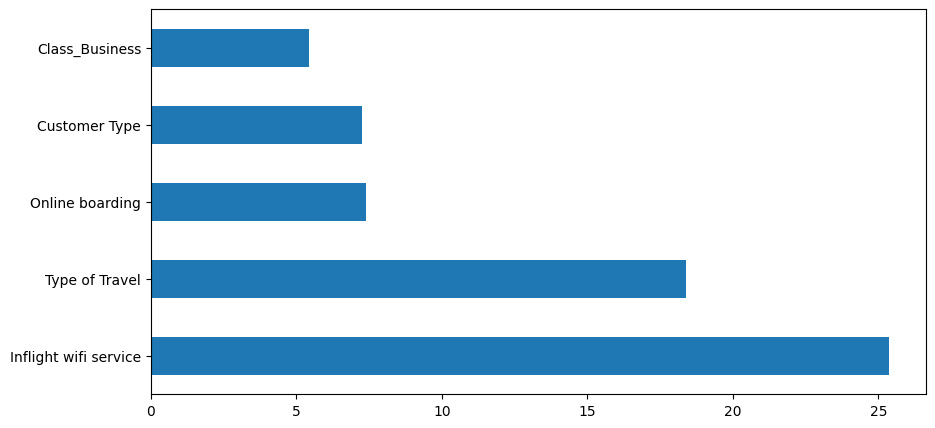

In [165]:
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(cb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')